In [34]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt


import torch
#from torch import Tensor as tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

from scipy.integrate import odeint
from scipy.integrate import RK45


from torch.autograd.functional import jacobian
import random



use_cuda = torch.cuda.is_available() #also worsk for AMD-ROCm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


# Pendelum
$$\frac{d^2 \theta}{dt^2}  +  \lambda\frac{d\theta}{dt} +  \frac{g}{l}sin(\theta) $$

In [318]:
def pend(y,t,b,c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5

theta_0 = np.pi
omega_0 = 1
 
y0 = [theta_0 , omega_0]

t_final = 10

t = np.arange(0, 10, 0.01)

sol = odeint(pend,y0, t, args=(b,c))


In [178]:
theta = 2*np.pi - sol[:, 0]
omega = sol[:, 1]

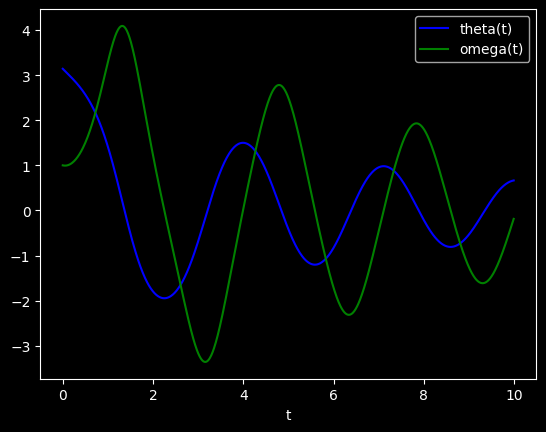

In [179]:
plt.plot(t, theta, 'b', label='theta(t)')
plt.plot(t, omega, 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

# Neural ODE with ajoint-sensitivity-method

In [12]:
def euler_forward(func, x_i, t_i, t_f, delta_t, return_seq=False):
    time = torch.arange(start=t_i, end=t_f, step=delta_t, requires_grad=False)
    x = x_i.clone().detach() #makes copy of init-tensor and remvoes gradients
    #x = x_i
    if not return_seq:
        for t in time:
            #x += delta_t*func(x)
            x = x + delta_t * func(x)
        return x
    if return_seq:
        x_list = []
        for t in time:
            x = x + delta_t * func(x)
            x_list.append(x)
        return torch.tensor(x_list)

In [264]:
def euler_forward_batch(func, x,t, propagation_time, delta_t, return_seq=False):
    time = torch.arange(start=0, end=propagation_time, step=delta_t, requires_grad=False)
    #x = x.clone().detach() #makes copy of init-tensor and remvoes gradients
    #t = t.clone().detach()
    if not return_seq:
        for t in time:
            x = x + delta_t * func(x,t).flatten()
        return x
    if return_seq:
        outputs = []
        for t in time:
            x = x + delta_t * func(x,t).flatten()
            outputs.append(x)
        return torch.tensor(outputs)

In [13]:
class ODEF(nn.Module):
    def forward_with_grad(self):
        pass
    def flatten_parameters(self):
        flat_parameters = []
        for param in self.parameters():
            flat_parameters.append(param.flatten())
        return torch.cat(flat_parameters)

In [336]:
class PendelumNetwork(ODEF):
    def __init__(self):
        super(PendelumNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 5, dtype=float),
            nn.ReLU(),
            nn.Linear(5, 5, dtype=float),
            nn.ReLU(),
            nn.Linear(5, 1, dtype=float)
        )
    def forward(self,x,t): #f(x(t), t)
        input_ = torch.zeros(2,len(x), dtype=float)
        input_[0] = x
        input_[1] = t
        input_ = input_.T
        return self.linear_relu_stack(input_)

In [15]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_i, t_i, t_f, flat_parameters, func, delta_t , return_whole_seq=False):
        assert isinstance(func, ODEF)

        with torch.no_grad():
            if return_whole_seq:
                return euler_forward(func, x_i, t_i, t_f, delta_t, True)
                #nof ctx since this part is only used for evaluation
            else:
                output = euler_forward(func, x_i, t_i, t_f, delta_t, False)
                ctx.func = func
                #ctx.save_for_backward(torch.tensor(t_f, dtype=float), output.clone(), flat_parameters)
                return output
        
    
    @staticmethod
    def backward(ctx, grad_outputs):
        #TODO
        return grad_outputs, None, None, None, None, None, None

In [142]:
class NeuralODE(nn.Module):
    def __init__(self, func, delta_t):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func
        self.delta_t = delta_t
    
    '''def forward(self, x_i, t_i , t_f, return_whole_seq=False):
        if return_whole_seq:
            return euler_forward(self.func, x_i, t_i, t_f, self.delta_t, True)
        else:
            return euler_forward(self.func, x_i, t_i, t_f, self.delta_t, False)'''

    def forward(self, x,t, propagation_time, return_seq=False):
        return euler_forward_batch(self.func, x,t, propagation_time, self.delta_t, return_seq)
        

In [348]:

N = 200
diff_t = 25
propagation_time = t[diff_t]

x_i = []
t_i = []
x_f = []

data_set = torch.zeros((3,N), dtype=float)



while len(t_i) < N:

    index = int(random.uniform(0, len(t)))

    if t[index]+delta_t > t[-1] or index+diff_t >= len(theta):
        continue

    t_i.append(t[index]) 
    x_i.append(theta[index])
    x_f.append(theta[index+diff_t])

t_i = torch.tensor(t_i)
x_i = torch.tensor(x_i)
x_f = torch.tensor(x_f)

#data normalization

#x_i = x_i/np.pi
#x_f = x_f/np.pi


data_set[0] = t_i
data_set[1] = x_i
data_set[2] = x_f
print("propagation_time, ", propagation_time)
data_set = data_set.T
data_set[:5]

propagation_time,  0.02


tensor([[ 3.6300,  1.1642,  1.2004],
        [ 6.0500, -0.7386, -0.7006],
        [ 8.5900, -0.8089, -0.8083],
        [ 7.7400,  0.2787,  0.2408],
        [ 9.3700,  0.0285,  0.0603]], dtype=torch.float64)

In [240]:
def createBatches(data_set, batch_size):
    batches = []
    number_of_batches = int(len(data_set)/batch_size)
    for i in range(number_of_batches):
        batches.append(data_set[i*batch_size:(i+1)*batch_size].T)
    number_of_batches = len(batches)
    return batches[:int(number_of_batches*0.75)], batches[int(number_of_batches*0.75):]


In [349]:
train, test = createBatches(data_set, 64)

t_i, x_i, x_f = train[0]
x_i, t_i

(tensor([ 1.1642, -0.7386, -0.8089,  0.2787,  0.0285,  0.1719,  0.5686, -1.2021,
          2.5689, -0.1575, -0.1163, -0.5807, -1.1925,  1.2417,  1.0634,  1.2666,
          1.4393, -0.5807, -0.8083,  0.5631,  1.4142, -1.6993,  1.3626,  1.4767,
         -0.5689, -0.0665, -1.1763, -0.3438, -0.4180, -0.1575, -1.0147, -1.2548,
          2.5838,  0.3979,  1.2177,  0.4789,  0.5536, -0.7669,  0.4614,  0.4179,
         -0.6970,  1.2076, -0.6443,  0.8072,  0.6994, -1.1892, -0.8028,  1.4735,
         -0.7933, -0.5923, -1.9468, -0.9820,  1.1826, -0.5321, -0.5962,  0.5006,
          0.5861,  0.4396,  0.2727, -0.5807,  2.6688, -0.2149,  0.7563, -0.7018],
        dtype=torch.float64),
 tensor([3.6300, 6.0500, 8.5900, 7.7400, 9.3700, 4.7800, 6.6600, 5.5700, 0.5000,
         6.3200, 9.2800, 8.9600, 5.5200, 4.3200, 1.1000, 3.6900, 4.1500, 8.9600,
         8.6100, 7.5800, 4.1800, 1.9300, 3.7600, 4.0900, 8.9700, 7.9200, 5.4800,
         4.9700, 8.1200, 6.3200, 2.8900, 2.8000, 0.4900, 6.5700, 3.6600, 7.630

In [350]:
#training
epoch = 500
delta_t = 0.02

func = PendelumNetwork()
model = NeuralODE(func, delta_t)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


for k in range(epoch):
    avg_los = 0
    for train_batch in train:
        t_i, x_i, real_value = train_batch
        prediction = model(x_i, t_i, propagation_time)
        loss = 1/2 * (prediction - real_value)@(prediction - real_value)
        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()
        avg_los += loss.item()
    if k%10==0:
        avg_los_2 = 0
        for test_batch in test:
            t_i, x_i, real_value = test_batch
            prediction_ = model(x_i, t_i, propagation_time)
            loss_ = 1/2 * (prediction - real_value)@(prediction - real_value)
            avg_los_2 += loss_.item()

        avg_los = avg_los/64
        avg_los_2 = avg_los_2/64
        print(k , "\t training ",avg_los)
        print(" \t validation ",avg_los_2)
        print("_________")


0 	 training  0.0014976408081109206
 	 validation  1.333432965340948
_________
10 	 training  0.001413723573529546
 	 validation  1.3220173695418267
_________
20 	 training  0.0014035225028808792
 	 validation  1.3231357300230329
_________
30 	 training  0.0014064545745401335
 	 validation  1.3236307311326194
_________
40 	 training  0.001406397448152925
 	 validation  1.3233847673604515
_________
50 	 training  0.0014048907657711344
 	 validation  1.3231399426854722
_________
60 	 training  0.0014043741131382678
 	 validation  1.323184078764711
_________
70 	 training  0.0014045057019644006
 	 validation  1.322919631590755
_________
80 	 training  0.001404592757938627
 	 validation  1.322996362311208
_________
90 	 training  0.0014047353114458499
 	 validation  1.3233109557224925
_________
100 	 training  0.001406986514269847
 	 validation  1.322824015767887
_________
110 	 training  0.0014030960846670242
 	 validation  1.3232125856548087
_________
120 	 training  0.001404295925660023

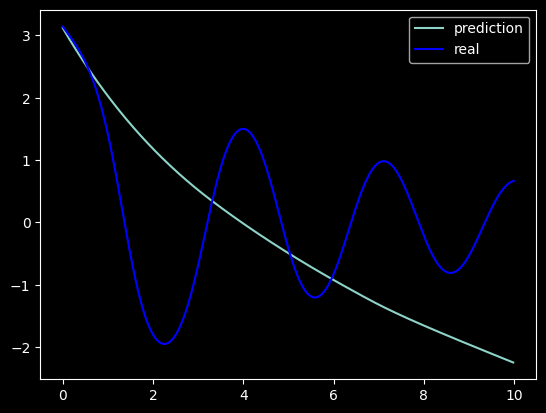

In [351]:
prediction = model(torch.tensor([np.pi],dtype=float), torch.tensor(0), 10, True)
plt.plot(np.arange(0, 10, delta_t),prediction, label="prediction")
plt.plot(t, theta, color='b',label="real")
plt.legend()
plt.show()

In [16]:
def one_euler_backward_step(func,x_1,delta_t):
    x = x_1.clone().detach()
    x -= delta_t * func(x)
    return x

def one_adjoint_backward_step(func, x_1, a_1, delta_t):

    a = a_1.clone().detach() 
    x = x_1.clone().detach()
    a -= delta_t * a * jacobian(func, x)

    return a



def get_gradient_with_respect_to_params(func, x):
    x = x.clone().detach()
    func(x).mean().backward()
    grads = []
    for param in func.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    f.zero_grad #<--- doesn't work
    return grads

def get_dL_dtheta(func, a_1, x_1, t_0, t_1, delta_t):
    time = torch.arange(start=t_0, end=t_1, step=delta_t, requires_grad=False)
    a = a_1.clone().detach() 
    x = x_1.clone().detach()
    result = torch.zeros( (a * get_gradient_with_respect_to_params(func, x)).shape)
    for t in time:
        result -= delta_t * a * get_gradient_with_respect_to_params(func, x)
        a = one_adjoint_backward_step(func, x, a, delta_t)
        x = one_euler_backward_step(func, x, delta_t)
    return result


def Loss_function(prediction):
    return (1/2  *  (theta[-1] - prediction)**2)
    

In [17]:
x_1 = euler_forward(f, x_0, 0, t_final,delta_t, False)
x_1

NameError: name 'f' is not defined

In [ ]:
loss = Loss_function(x_1)
loss

tensor([2.1752], dtype=torch.float64, grad_fn=<MulBackward0>)

In [ ]:
a_1 = jacobian(Loss_function, x_1)
a_1

tensor([[-2.0857]], dtype=torch.float64)

In [ ]:
get_dL_dtheta(f, a_1, x_1, 0, t_final, delta_t)

tensor([[  5182.3940,   2615.4062, -62377.1914,   3572.2505,   2093.1956,
          20063.4766,    464.5010,   1353.3417,   1707.2321,   1040.1328,
           3030.5242,   3822.8762,   1118.2527,   3258.1165,   4110.0825,
           8105.8228,  18150.9785,  19514.4199,  11215.4150,  15596.4209,
           8865.2666,  37163.9062]])

In [ ]:
for param in f.parameters():
    param.data = nn.parameter.Parameter(torch.rand_like(param))

# Sanity check-


In [ ]:
for param in f.parameters():
    print(param)

Parameter containing:
tensor([[0.2703],
        [0.6653],
        [0.0603]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.0263, 0.2417, 0.4640], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0.8103, 0.1916, 0.5303],
        [0.8317, 0.3430, 0.2151],
        [0.2263, 0.2908, 0.9295]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.3784, 0.6403, 0.1921], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0.4109, 0.9200, 0.9891]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.0126], dtype=torch.float64, requires_grad=True)
